In [1]:
import json
import random
from itertools import product

import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"

from vgc_project.construal_search import \
    ConstrualSearch, ExhaustiveSearch, BreadthFirstSearch, DepthFirstSearch, \
    EventListener, BoundedDepthFirstSearch

class BDFS2(BoundedDepthFirstSearch):
    bound = 2
class BDFS3(BoundedDepthFirstSearch):
    bound = 3
class BDFS4(BoundedDepthFirstSearch):
    bound = 4
class BDFS5(BoundedDepthFirstSearch):
    bound = 5
class BDFS6(BoundedDepthFirstSearch):
    bound = 6

In [2]:
mazes = {
    **json.load(open("../experiments/mazes/mazes_0-11.json", 'r')),
    **json.load(open("../experiments/mazes/mazes_12-15.json", 'r'))
}

# Comparison of BFS and Exhaustive Search results

In [3]:
rng = random.Random(112893)
max_iterations = 1000
construal_value_threshold = -35
bfs_comparison = []
maze_stats = {}
for maze_name in mazes.keys():
    gw_params = dict(
        tile_array=tuple(mazes[maze_name]),
        feature_rewards=(("G", 0), ),
        absorbing_features=("G",),
        wall_features="#0123456789",
        default_features=(".",),
        initial_features=("S",),
        step_cost=-1,
        discount_rate=.99
    )
    exhaustive = ExhaustiveSearch(
        gw_params=gw_params,
        max_iterations=max_iterations,
        construal_value_threshold=construal_value_threshold,
    )
    ex_res = exhaustive.search(rng=rng)
    maze_stats[maze_name] = {
        'total_construals': len(ex_res.construal_values),
        'optimal_construal_size': len(list(ex_res.max_construals)[0])
    }
    bfs = BreadthFirstSearch(
        gw_params=gw_params,
        max_iterations=max_iterations,
        construal_value_threshold=construal_value_threshold,
    )
    bfs_res = bfs.search(rng=rng)
    ex_c = set(list(ex_res.max_construals)[0]) 
    bfs_c = set(list(bfs_res.max_construals)[0])
    bfs_comparison.append({
        "maze": maze_name,
        "matches_exhaustive": ex_c == bfs_c,
        "subset_exhaustive": bfs_c < ex_c,
        "bfs_value": bfs_res.max_value,
        "ex_value": ex_res.max_value
    })

In [4]:
bfs_comparison = pd.DataFrame(bfs_comparison)
bfs_comparison['bfs_value_diff'] = bfs_comparison['bfs_value'] - bfs_comparison['ex_value']
bfs_comparison.mean()

matches_exhaustive     0.625000
subset_exhaustive      0.375000
bfs_value            -24.778343
ex_value             -24.205172
bfs_value_diff        -0.573171
dtype: float64

# Computational cost comparison

In [5]:
sims = []
rng = random.Random(112893)
max_iterations = 1000
runs = 500
for \
    maze_name, \
    construal_value_threshold, \
    Strategy, \
    _ \
    in tqdm.tqdm(list(product(
        mazes.keys(),
        [-35],
        [ExhaustiveSearch, BreadthFirstSearch, DepthFirstSearch, BDFS2, BDFS3, BDFS4, BDFS5, BDFS6],
        range(runs)
    ))):
    gw_params = dict(
        tile_array=tuple(mazes[maze_name]),
        feature_rewards=(("G", 0), ),
        absorbing_features=("G",),
        wall_features="#0123456789",
        default_features=(".",),
        initial_features=("S",),
        step_cost=-1,
        discount_rate=.99
    )
    event_listener = EventListener()
    strategy = Strategy(
        gw_params=gw_params,
        max_iterations=max_iterations,
        construal_value_threshold=construal_value_threshold,
    )
    res = strategy.search(event_listener, rng=rng)
    sims.append(dict(
        **strategy.params(),
        construal_size=np.mean([len(c) for c in res.max_construals]),
        max_construal_size=max([len(c) for c in res.construal_values]),
        construal_utility=np.mean(list(res.max_construals_utilities.values())),
        maze_name=maze_name,
        construals_evaluated=len(res.construal_values),
        value=res.max_value
    ))

100%|██████████| 64000/64000 [02:09<00:00, 493.78it/s] 


In [6]:
sims = pd.DataFrame(sims)
sims["Maze"] = sims['maze_name'].apply(lambda n: n.split('-')[1])
sims["path_length"] = -sims['construal_utility']
sims['search_class'] = sims['search_class'].astype('category')
search_class_order = [
    'ExhaustiveSearch',
    'BreadthFirstSearch',
    'BDFS2',
    'BDFS3',
    'BDFS4',
    'BDFS5',
    'BDFS6',
    'DepthFirstSearch',
]
hue_order = [
    'ExhaustiveSearch',
    'BreadthFirstSearch',
    'BDFS2',
    'BDFS3',
    'BDFS4',
    'BDFS5',
    'BDFS6',
    'DepthFirstSearch',
]
bdfs_palette = list(sns.color_palette("flare", n_colors=7))
palette=['green'] + bdfs_palette
sims['search_class'] = sims['search_class'].cat.reorder_categories(search_class_order)

In [7]:
sims['construals_evaluated_prop'] = sims.apply(lambda r: r['construals_evaluated']/maze_stats[r['maze_name']]['total_construals'], axis=1)
sims['construals_size_prop'] = sims.apply(lambda r: r['construal_size']/maze_stats[r['maze_name']]['optimal_construal_size'], axis=1)

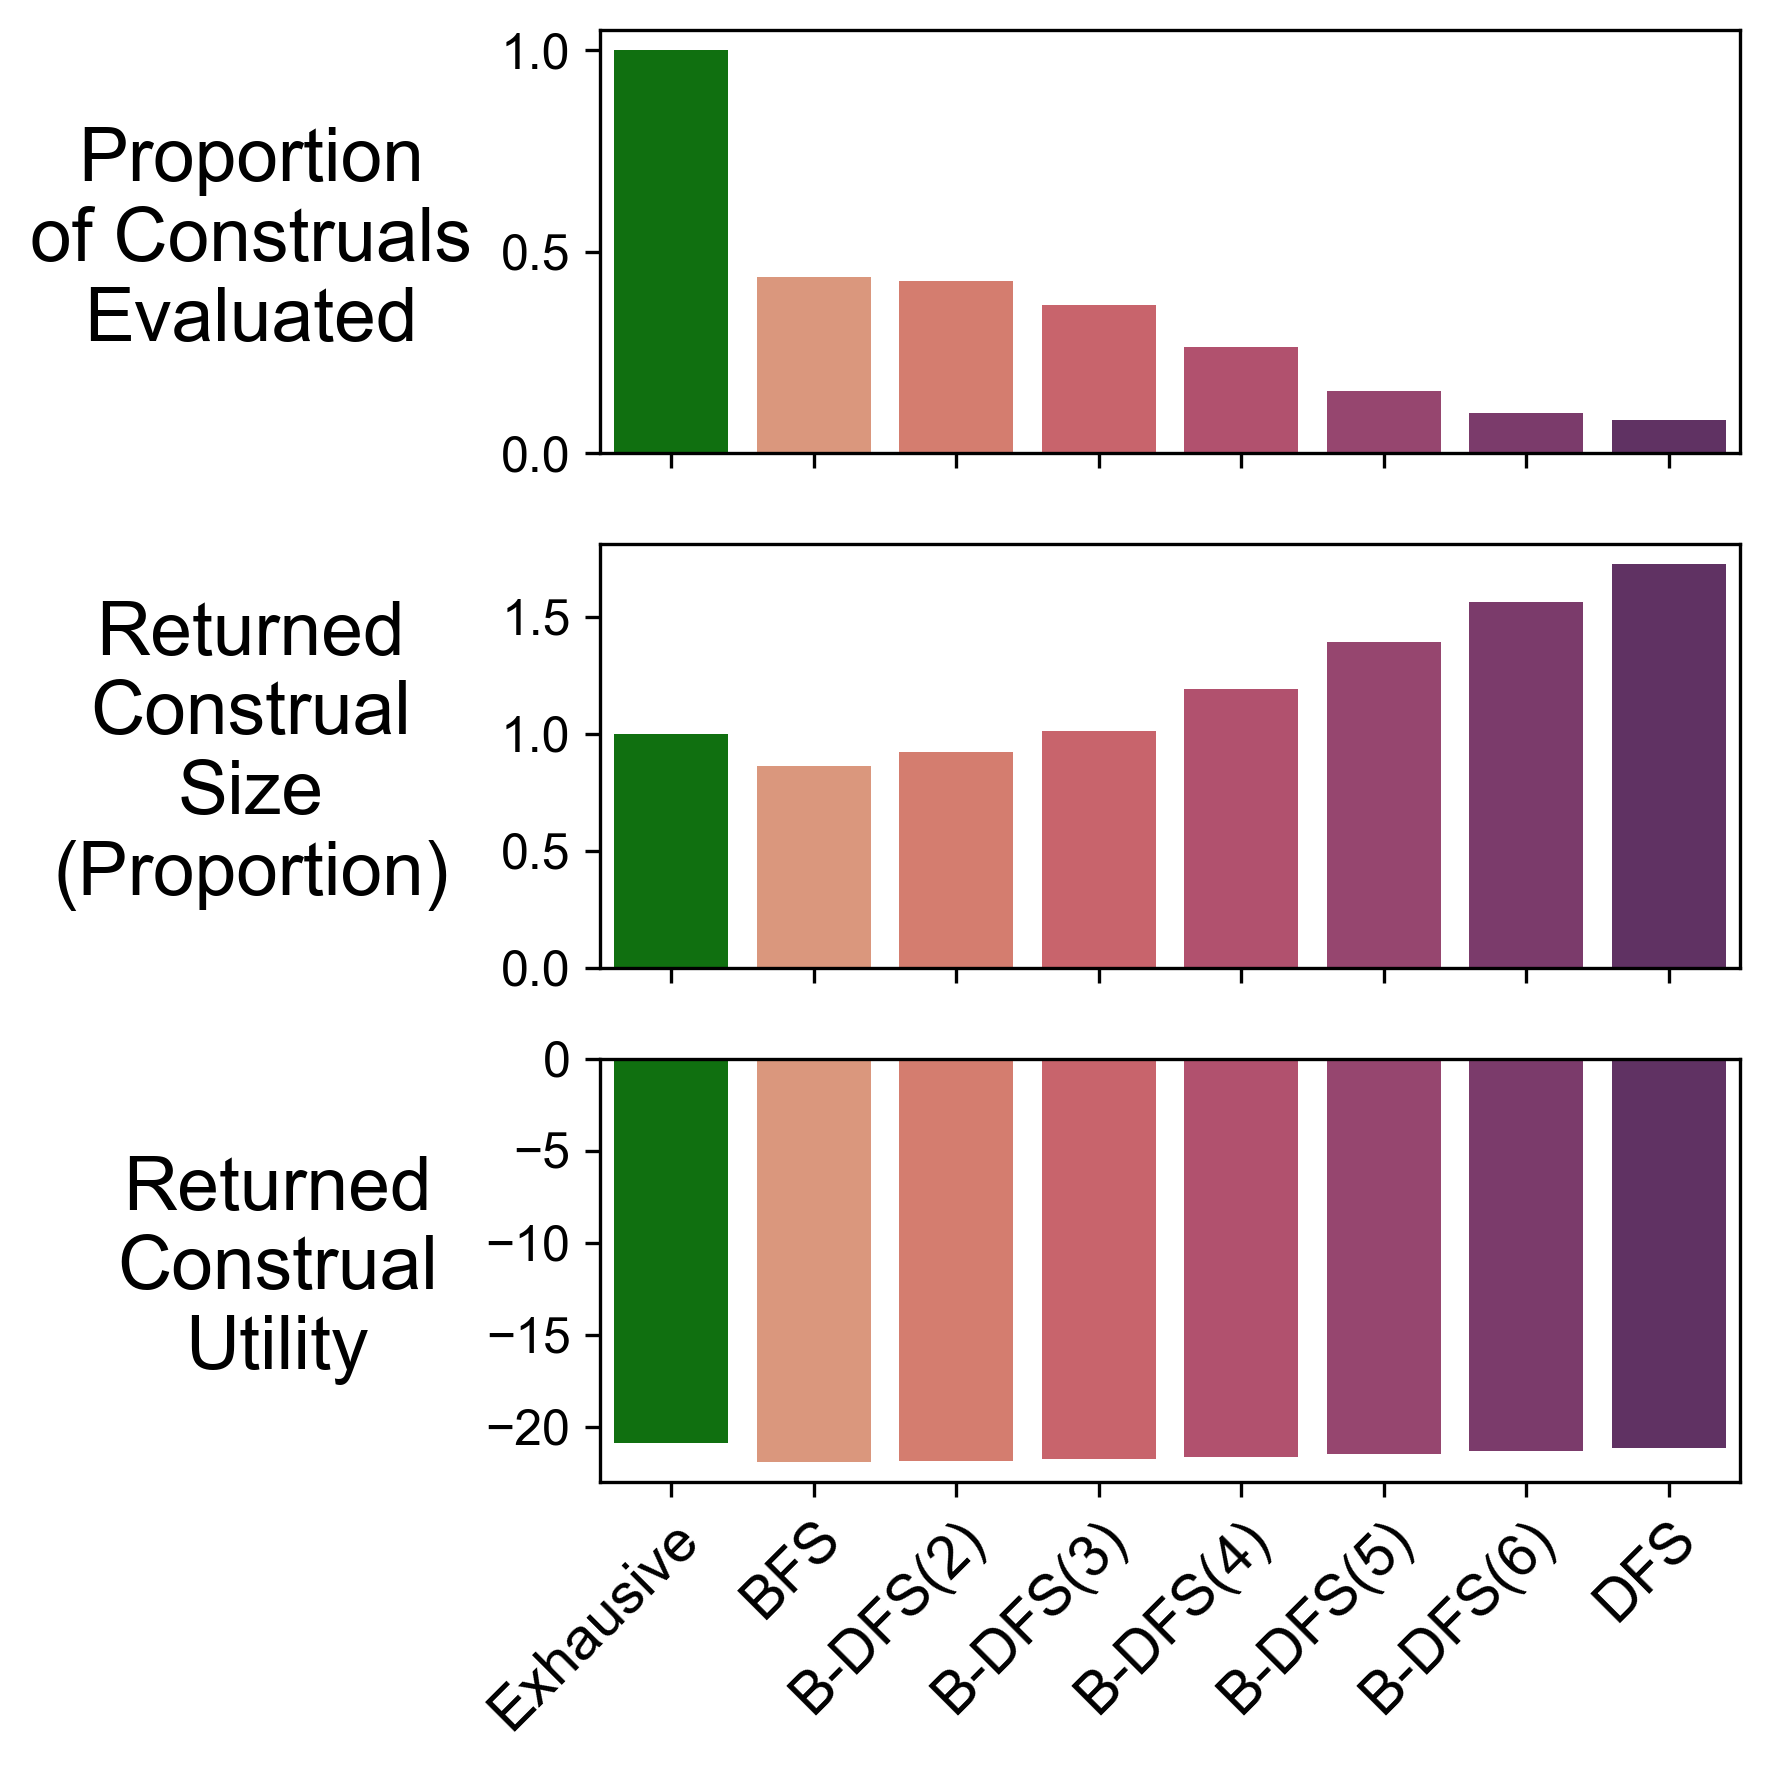

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), dpi=300)
axes = list(axes.flatten())
g = sns.barplot(
    data=sims,
    x='search_class',
    y='construals_evaluated_prop',
    # hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci=None,
    ax=axes.pop(0)
)
g.tick_params(axis='y', labelsize=12)

ylab = g.set_ylabel("Proportion\nof Construals\nEvaluated", rotation=0, labelpad=60, va="center", size=18)
g.set(xlabel=None, xticklabels=[])

g = sns.barplot(
    data=sims,
    x='search_class',
    y='construals_size_prop',
    # hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci=None,
    ax=axes.pop(0)
)
g.tick_params(axis='y', labelsize=12)
ylab = g.set_ylabel("Returned\nConstrual\nSize\n(Proportion)", rotation=0, labelpad=60, va="center", size=18)
g.set(xlabel=None, xticklabels=[])

g = sns.barplot(
    data=sims,
    x='search_class',
    y='construal_utility',
    # hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci=None,
    ax=axes.pop(0)
)
g.set_xticklabels(
    [
        'Exhausive',
        'BFS',
        'B-DFS(2)',
        'B-DFS(3)',
        'B-DFS(4)',
        'B-DFS(5)',
        'B-DFS(6)',
        'DFS'
    ], 
    rotation=45,
    rotation_mode='anchor',
    ha='right',
    fontsize=14
)
g.set_xlabel(None)

ylab = g.set_ylabel("Returned\nConstrual\nUtility", rotation=0, labelpad=50, va="center", size=18)
_ = plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("construal_search_means.png")

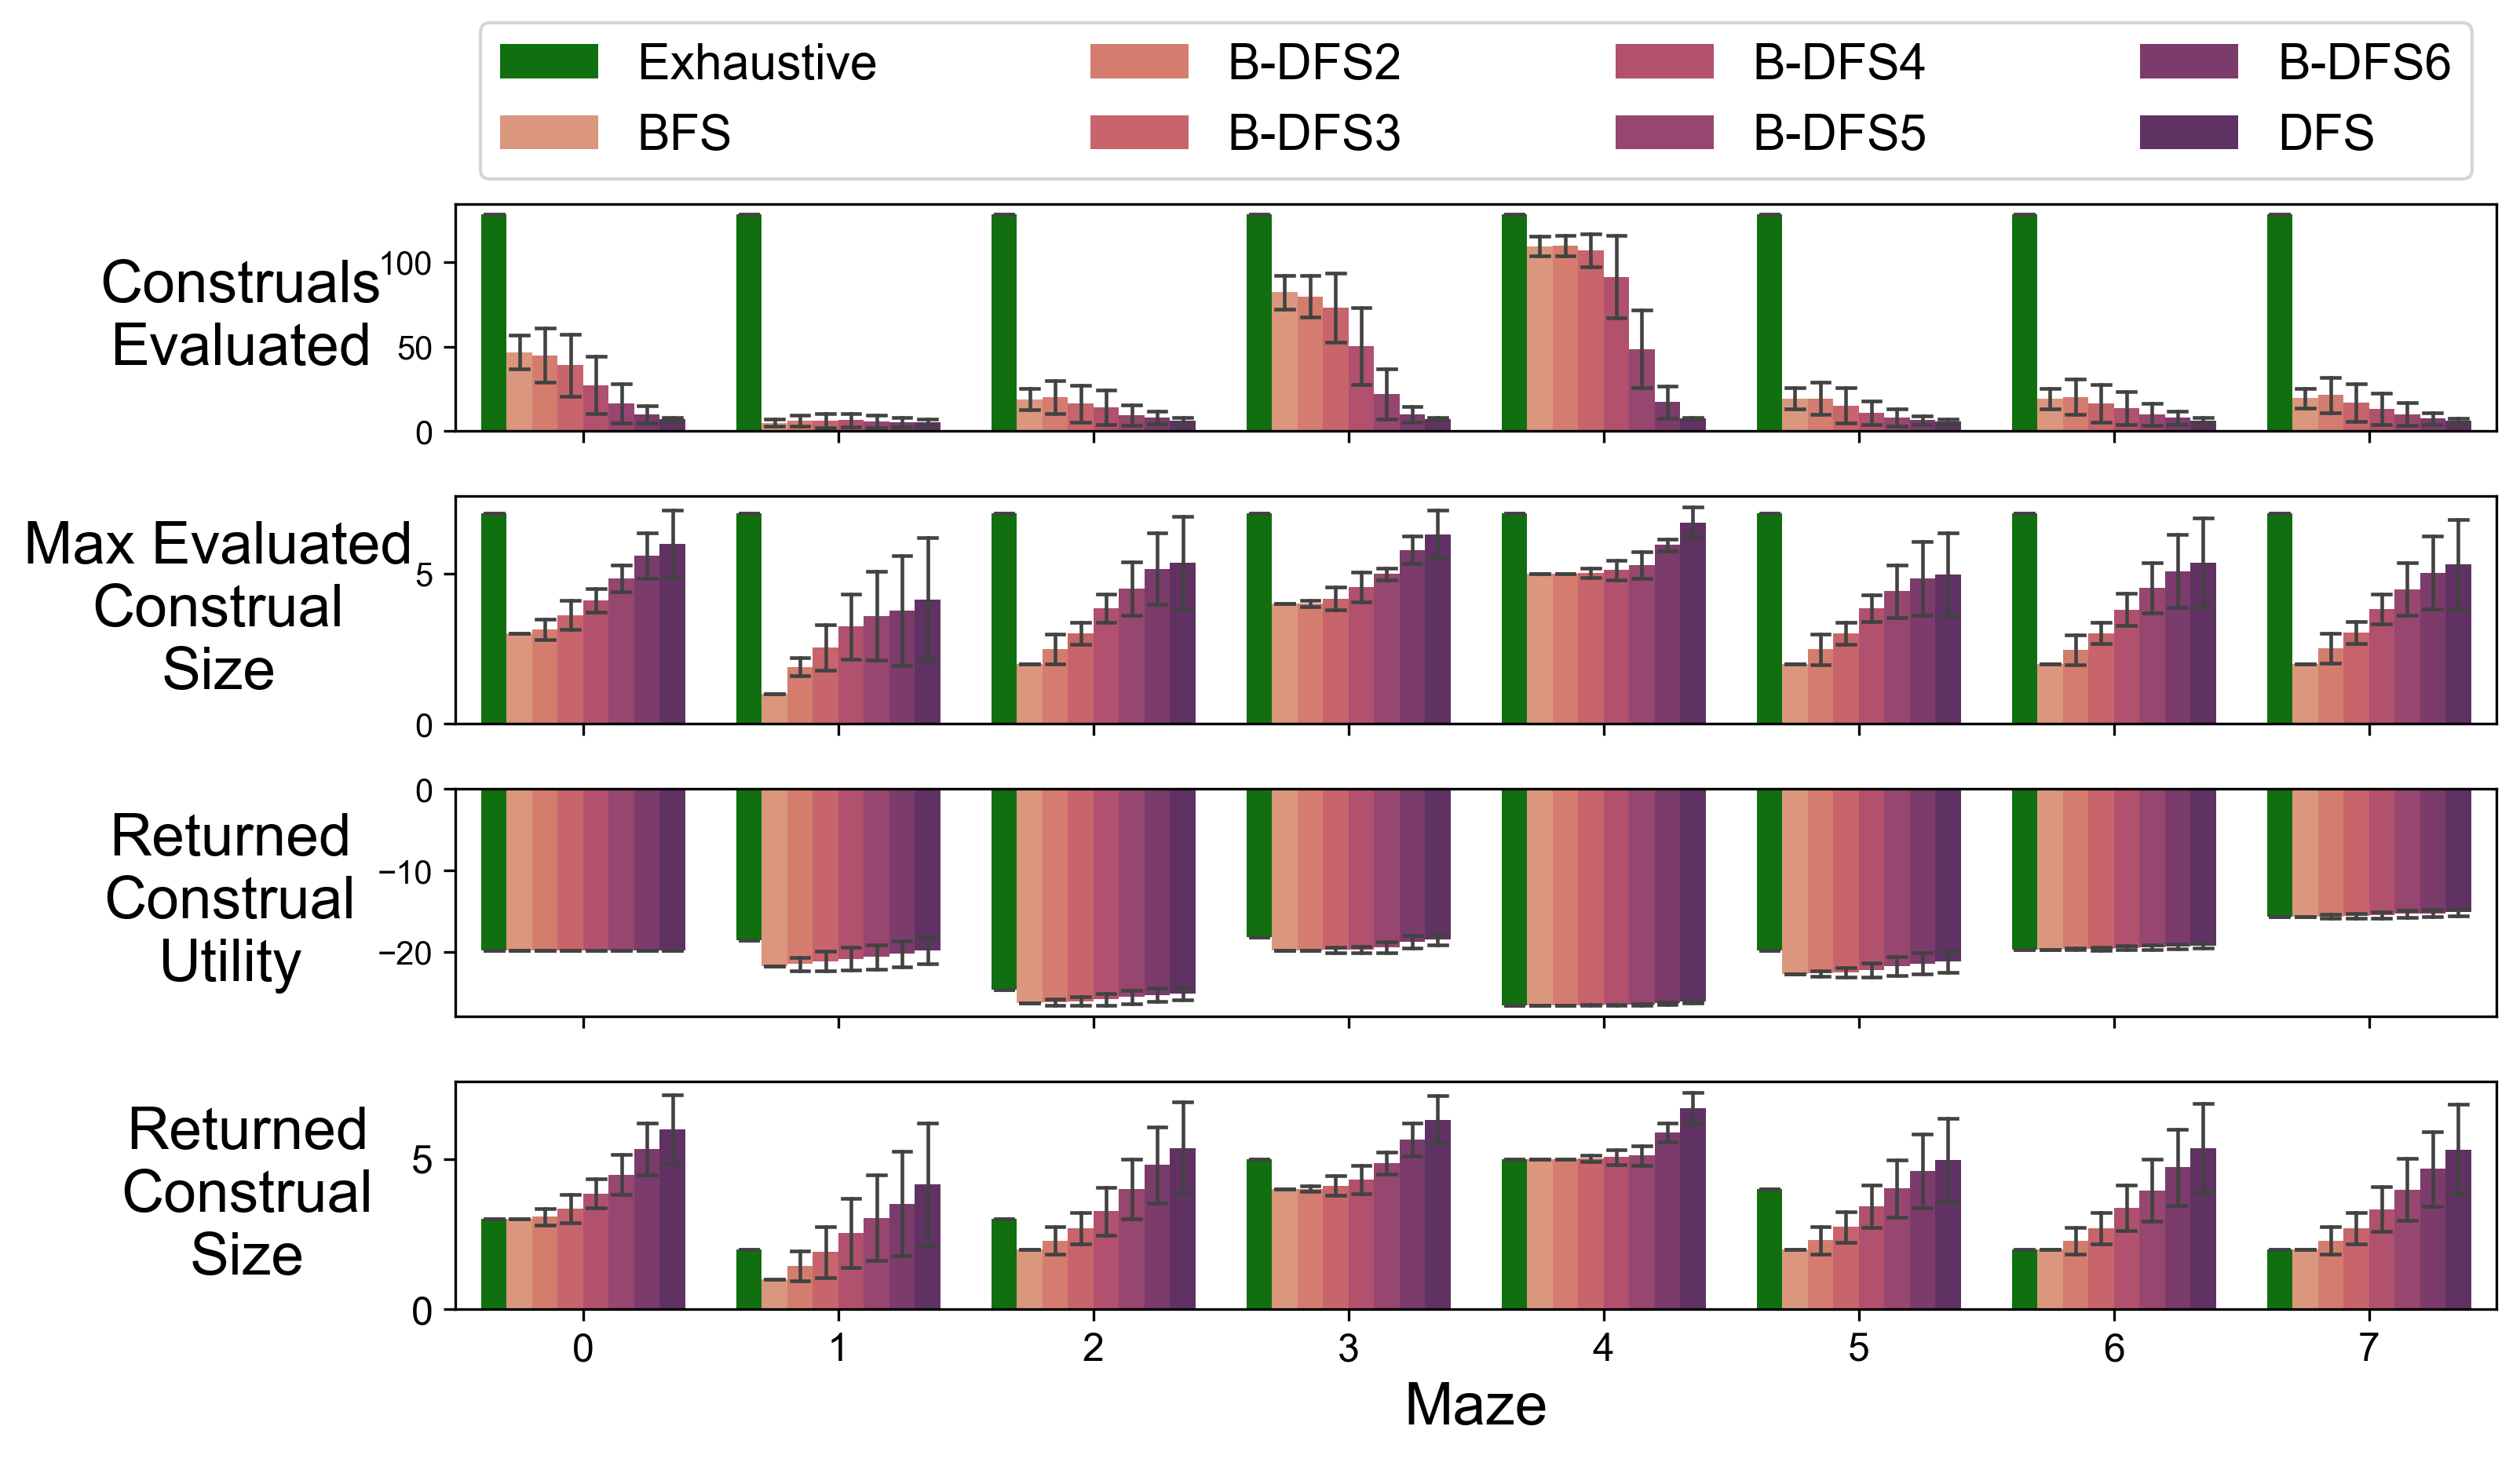

In [9]:
to_plot = sims[sims["Maze"].apply(lambda m: int(m) in range(8))]
fig, axes = plt.subplots(4, 1, figsize=(12*.9, 7*.9), dpi=300)
axes = list(axes.flatten())
capsize = .07
errwidth = 1.1
g = sns.barplot(
    data=to_plot,
    x='Maze',
    y='construals_evaluated',
    hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci='sd',
    errwidth=errwidth,
    capsize=capsize,
    ax=axes.pop(0)
)
g.set(xlabel=None, xticklabels=[])
new_labels = ["Exhaustive", "BFS", "B-DFS2", "B-DFS3", "B-DFS4", "B-DFS5", "B-DFS6", "DFS"]
g.legend(
    bbox_to_anchor=(0, 1, 1, 0),
    loc="lower left",
    mode="expand",
    ncol=4,
    handles=g.legend().get_patches(),
    labels=new_labels,
    fontsize=15
)
ylab = g.set_ylabel("Construals\nEvaluated", rotation=0, labelpad=42, va="center", size=18)
_ = plt.yticks(fontsize=12)
g = sns.barplot(
    data=to_plot,
    x='Maze',
    y='max_construal_size',
    hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci='sd',
    errwidth=errwidth,
    capsize=capsize,
    ax=axes.pop(0)
)
g.get_legend().remove()
g.set(xlabel=None, xticklabels=[])
ylab = g.set_ylabel("Max Evaluated\nConstrual\nSize", rotation=0, labelpad=60, va="center", size=18)
_ = plt.yticks(fontsize=12)

g = sns.barplot(
    data=to_plot,
    x='Maze',
    y='construal_utility',
    hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci='sd',
    errwidth=errwidth,
    capsize=capsize,
    ax=axes.pop(0)
)
g.get_legend().remove()
g.set(xlabel=None, xticklabels=[])
ylab = g.set_ylabel("Returned\nConstrual\nUtility", rotation=0, labelpad=45, va="center", size=18)
_ = plt.yticks(fontsize=12)
g = sns.barplot(
    data=to_plot,
    x='Maze',
    y='construal_size',
    hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci='sd',
    errwidth=errwidth,
    capsize=capsize,
    ax=axes.pop(0)
)
g.get_legend().remove()
g.xaxis.label.set_size(18)
_ = plt.xticks(fontsize=12)
ylab = g.set_ylabel("Returned\nConstrual\nSize", rotation=0, labelpad=50, va="center", size=18)
_ = plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("construal_search_0_7.png")

In [10]:
def mazes_summary_boxplots(
    to_plot,
    measure,
    measure_label,
    ax,
    search_class_order,
    bdfs_palette,
    measure_label_pad=50,
    show_x_labels=True,
    show_legend=True,
):
    to_plot_exhaustive = to_plot[to_plot['search_class'] == "ExhaustiveSearch"]
    to_plot_bdfs = to_plot[to_plot['search_class'] != "ExhaustiveSearch"]
    g = sns.boxplot(
        data=to_plot_bdfs,
        x='Maze',
        y=measure,
        hue='search_class', 
        hue_order=search_class_order,
        palette=bdfs_palette,
        linewidth=.5,
        fliersize=1,
        ax=ax
    )
    # plot exhaustive
    g_xticklabels = [t.get_text() for t in g.get_xticklabels()]
    g_xticks = g.get_xticks()
    for maze_str, xtick in zip(g_xticklabels, g_xticks):
        ex_mean = to_plot_exhaustive[to_plot_exhaustive.Maze == maze_str][measure].mean()
        g.plot([xtick-.4, xtick+.4], [ex_mean, ex_mean], 'g--', linewidth=.75)

    ylab = g.set_ylabel(measure_label, rotation=0, labelpad=measure_label_pad, va="center", size=18)
    _ = plt.yticks(fontsize=12)
    if not show_x_labels:
        g.set(xlabel=None, xticklabels=[])
    else:
        g.xaxis.label.set_size(18)
        _ = plt.xticks(fontsize=12)
    if show_legend:
        new_labels = ["BFS", "B-DFS2", "B-DFS3", "B-DFS4", "B-DFS5", "B-DFS6", "DFS"]
        g.legend(
            bbox_to_anchor=(0, 1, 1, 0),
            loc="lower left",
            mode="expand",
            ncol=4,
            handles=g.legend().get_patches(),
            labels=new_labels,
            fontsize=15
        )
    else:
        g.get_legend().remove()
    return g

In [11]:
bdfs_hue_order = ['BreadthFirstSearch', 'BDFS2', 'BDFS3', 'BDFS4', 'BDFS5', 'BDFS6', 'DepthFirstSearch']

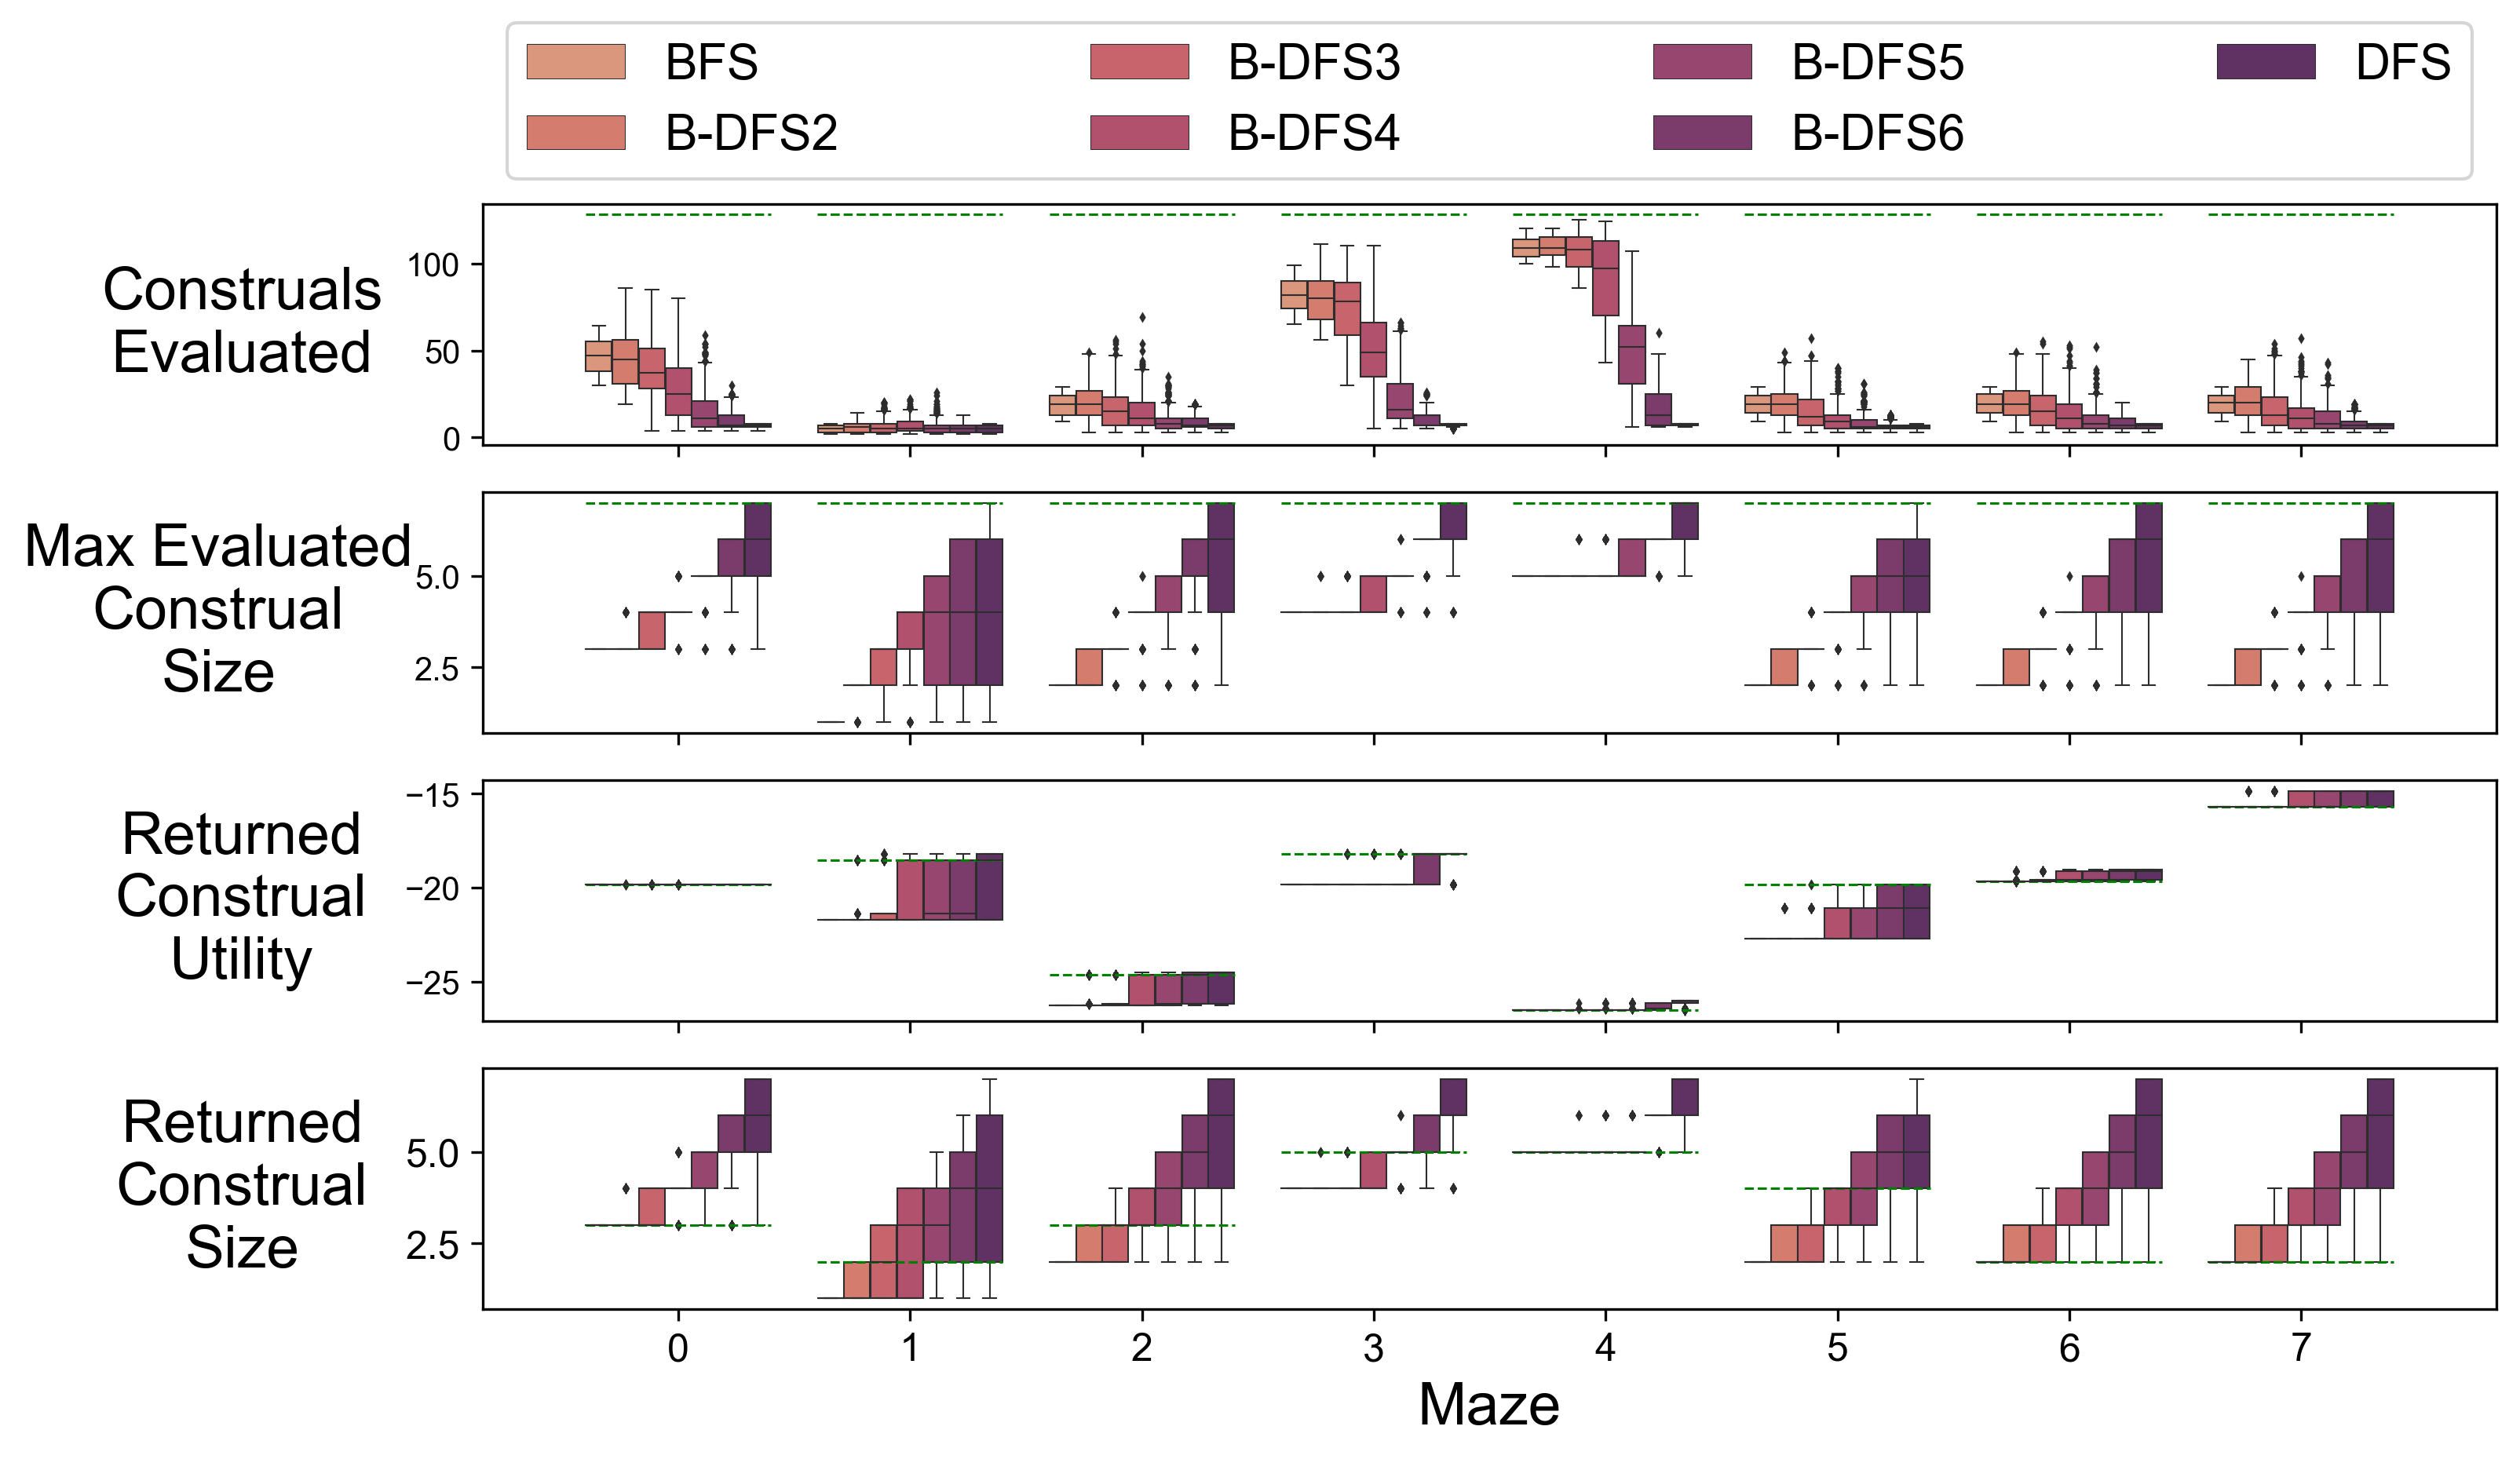

In [12]:
to_plot = sims[sims["Maze"].apply(lambda m: int(m) in range(8))]
fig, axes = plt.subplots(4, 1, figsize=(12*.9, 7*.9), dpi=300)
axes = list(axes.flatten())

g = mazes_summary_boxplots(
    to_plot=to_plot,
    measure='construals_evaluated',
    measure_label="Construals\nEvaluated",
    ax=axes.pop(0),
    search_class_order=bdfs_hue_order,
    bdfs_palette=bdfs_palette,
    show_x_labels=False,
    show_legend=True,
)
g = mazes_summary_boxplots(
    to_plot=to_plot,
    measure='max_construal_size',
    measure_label="Max Evaluated\nConstrual\nSize",
    ax=axes.pop(0),
    search_class_order=bdfs_hue_order,
    bdfs_palette=bdfs_palette,
    show_x_labels=False,
    show_legend=False,
    measure_label_pad=60
)
g = mazes_summary_boxplots(
    to_plot=to_plot,
    measure='construal_utility',
    measure_label="Returned\nConstrual\nUtility",
    ax=axes.pop(0),
    search_class_order=bdfs_hue_order,
    bdfs_palette=bdfs_palette,
    show_x_labels=False,
    show_legend=False,
)
g = mazes_summary_boxplots(
    to_plot=to_plot,
    measure='construal_size',
    measure_label="Returned\nConstrual\nSize",
    ax=axes.pop(0),
    search_class_order=bdfs_hue_order,
    bdfs_palette=bdfs_palette,
    show_x_labels=True,
    show_legend=False,
)
plt.tight_layout()
plt.savefig("construal_search_boxplots_0_7.png")

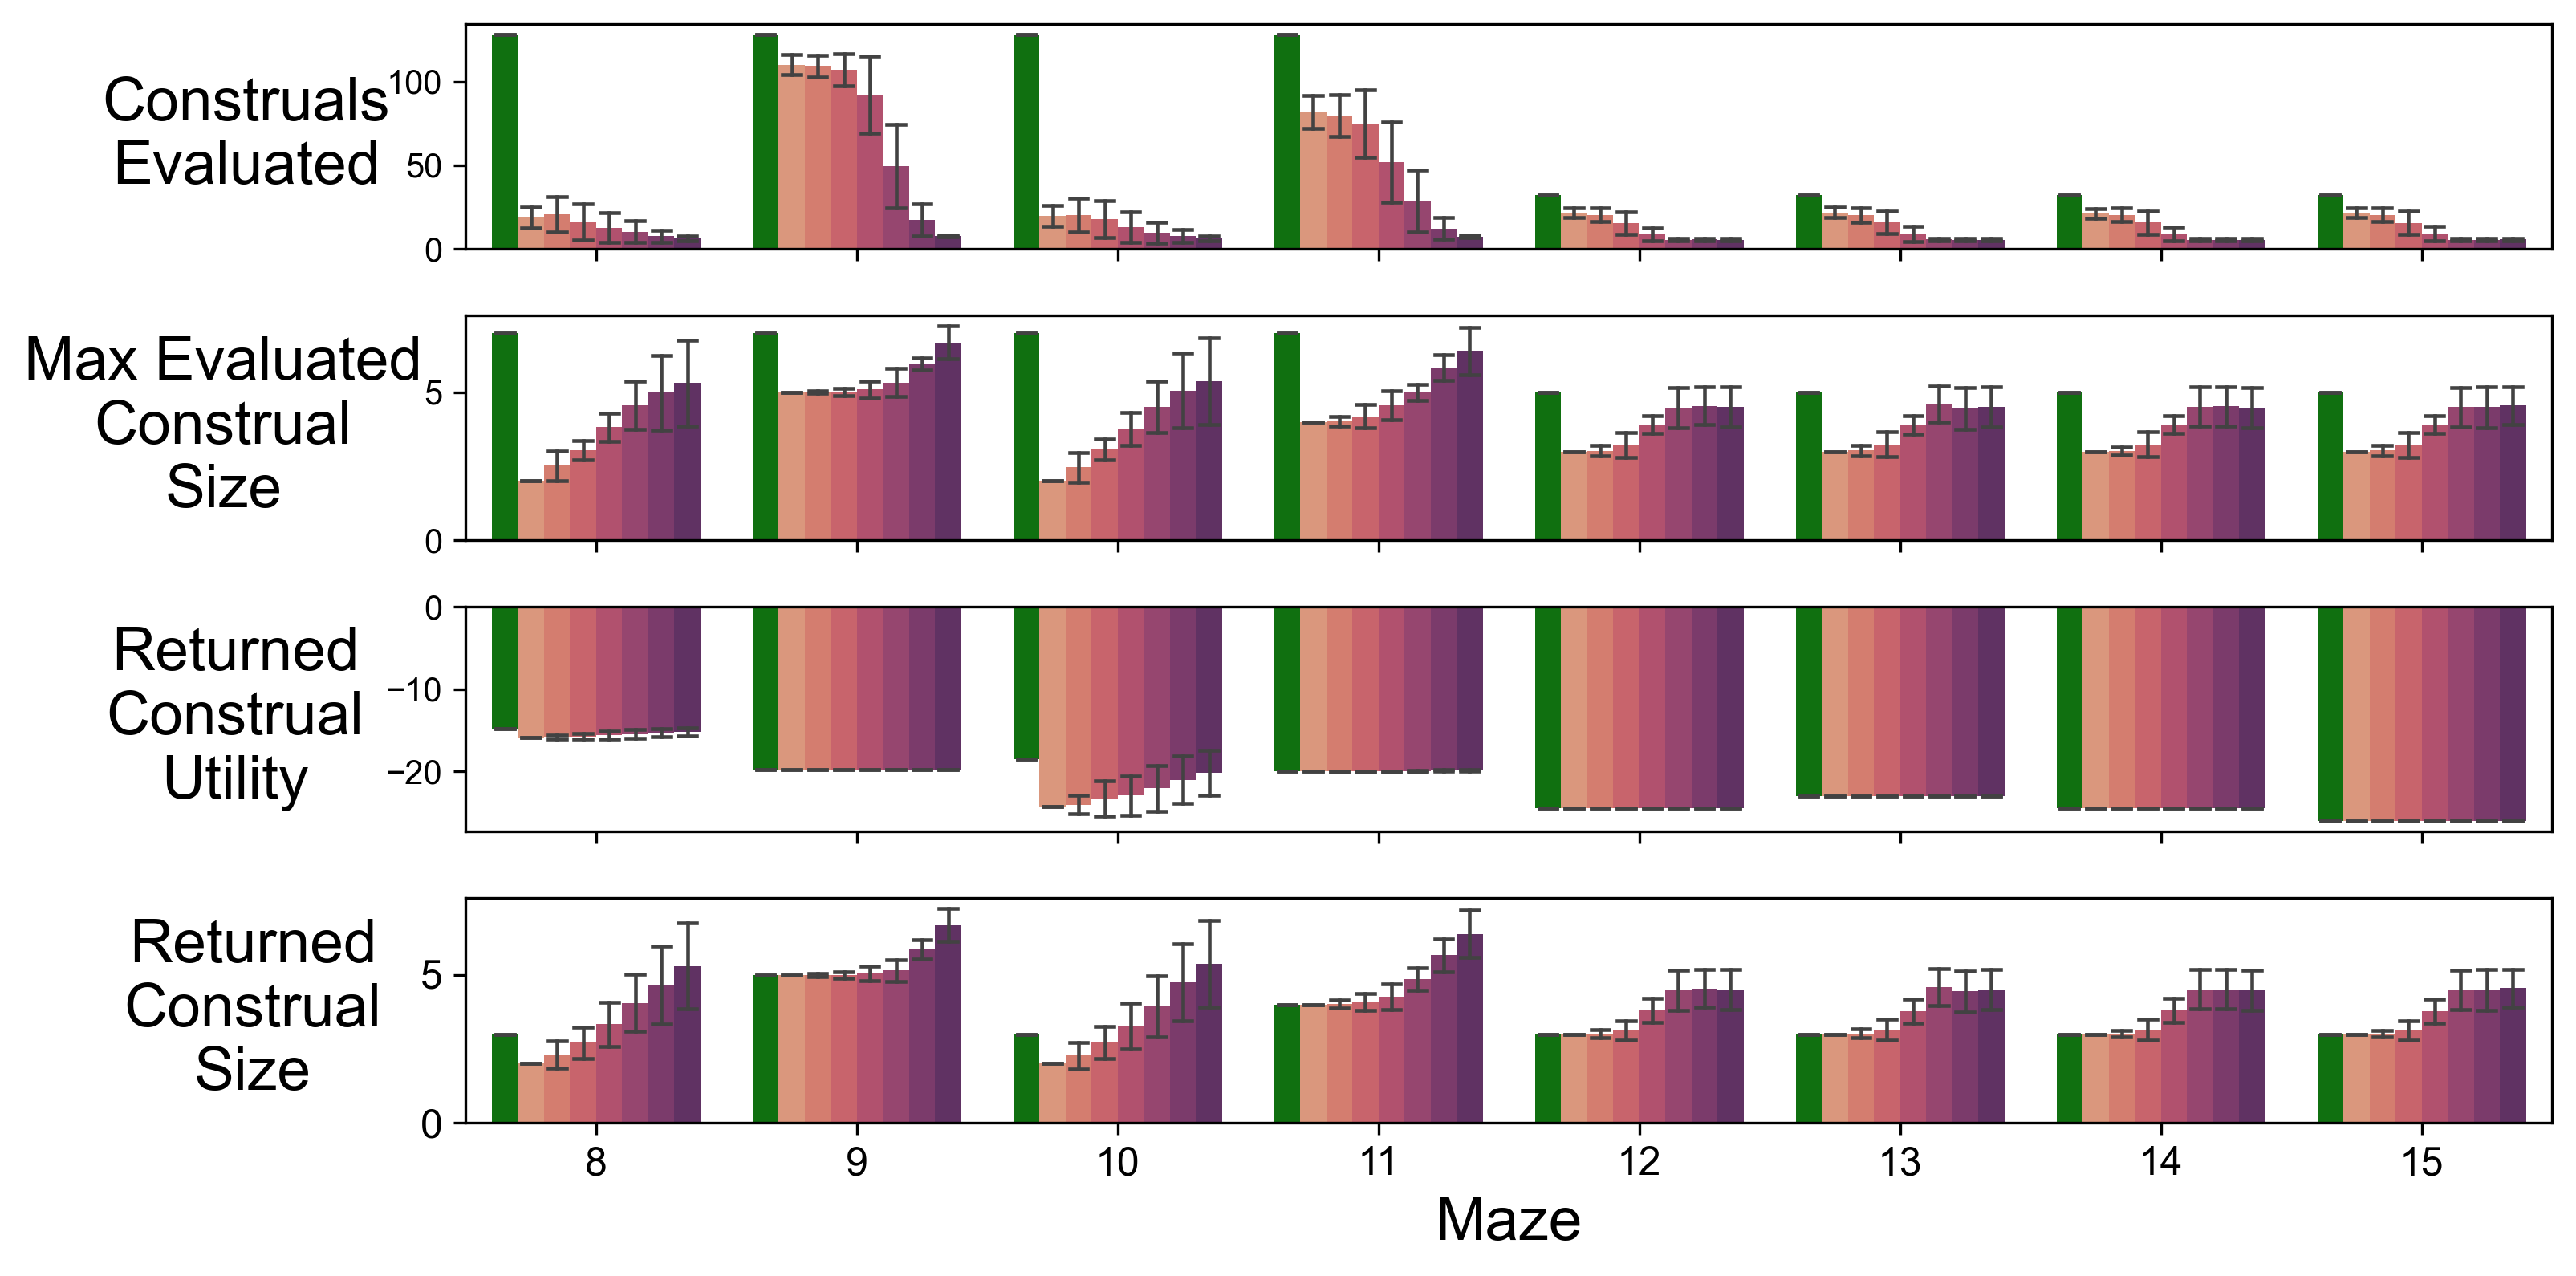

In [13]:
to_plot = sims[sims["Maze"].apply(lambda m: int(m) in range(8,16))]
fig, axes = plt.subplots(4, 1, figsize=(12*.9, 6*.9), dpi=300)
axes = list(axes.flatten())
capsize = .07
errwidth = 1.1
palette=['green'] + list(sns.color_palette("flare", n_colors=7))
hue_order = [
    'ExhaustiveSearch',
    'BreadthFirstSearch',
    'BDFS2',
    'BDFS3',
    'BDFS4',
    'BDFS5',
    'BDFS6',
    'DepthFirstSearch',
]
g = sns.barplot(
    data=to_plot,
    x='Maze',
    y='construals_evaluated',
    hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci='sd',
    errwidth=errwidth,
    capsize=capsize,
    ax=axes.pop(0)
)
g.set(xlabel=None, xticklabels=[])
g.get_legend().remove()
# new_labels = ["Exhaustive", "BFS", "B-DFS2", "B-DFS3", "B-DFS4", "B-DFS5", "DFS"]
# g.legend(
#     bbox_to_anchor=(0, 1, 1, 0),
#     loc="lower left",
#     mode="expand",
#     ncol=4,
#     handles=g.legend().get_patches(),
#     labels=new_labels,
#     fontsize=15
# )
ylab = g.set_ylabel("Construals\nEvaluated", rotation=0, labelpad=42, va="center", size=18)
_ = plt.yticks(fontsize=12)
g = sns.barplot(
    data=to_plot,
    x='Maze',
    y='max_construal_size',
    hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci='sd',
    errwidth=errwidth,
    capsize=capsize,
    ax=axes.pop(0)
)
g.get_legend().remove()
g.set(xlabel=None, xticklabels=[])
ylab = g.set_ylabel("Max Evaluated\nConstrual\nSize", rotation=0, labelpad=60, va="center", size=18)
_ = plt.yticks(fontsize=12)

g = sns.barplot(
    data=to_plot,
    x='Maze',
    y='construal_utility',
    hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci='sd',
    errwidth=errwidth,
    capsize=capsize,
    ax=axes.pop(0)
)
g.get_legend().remove()
g.set(xlabel=None, xticklabels=[])
ylab = g.set_ylabel("Returned\nConstrual\nUtility", rotation=0, labelpad=45, va="center", size=18)
_ = plt.yticks(fontsize=12)
g = sns.barplot(
    data=to_plot,
    x='Maze',
    y='construal_size',
    hue='search_class', 
    hue_order=hue_order,
    palette=palette,
    ci='sd',
    errwidth=errwidth,
    capsize=capsize,
    ax=axes.pop(0)
)
g.get_legend().remove()
g.xaxis.label.set_size(18)
_ = plt.xticks(fontsize=12)
ylab = g.set_ylabel("Returned\nConstrual\nSize", rotation=0, labelpad=50, va="center", size=18)
_ = plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("construal_search_8_15.png")

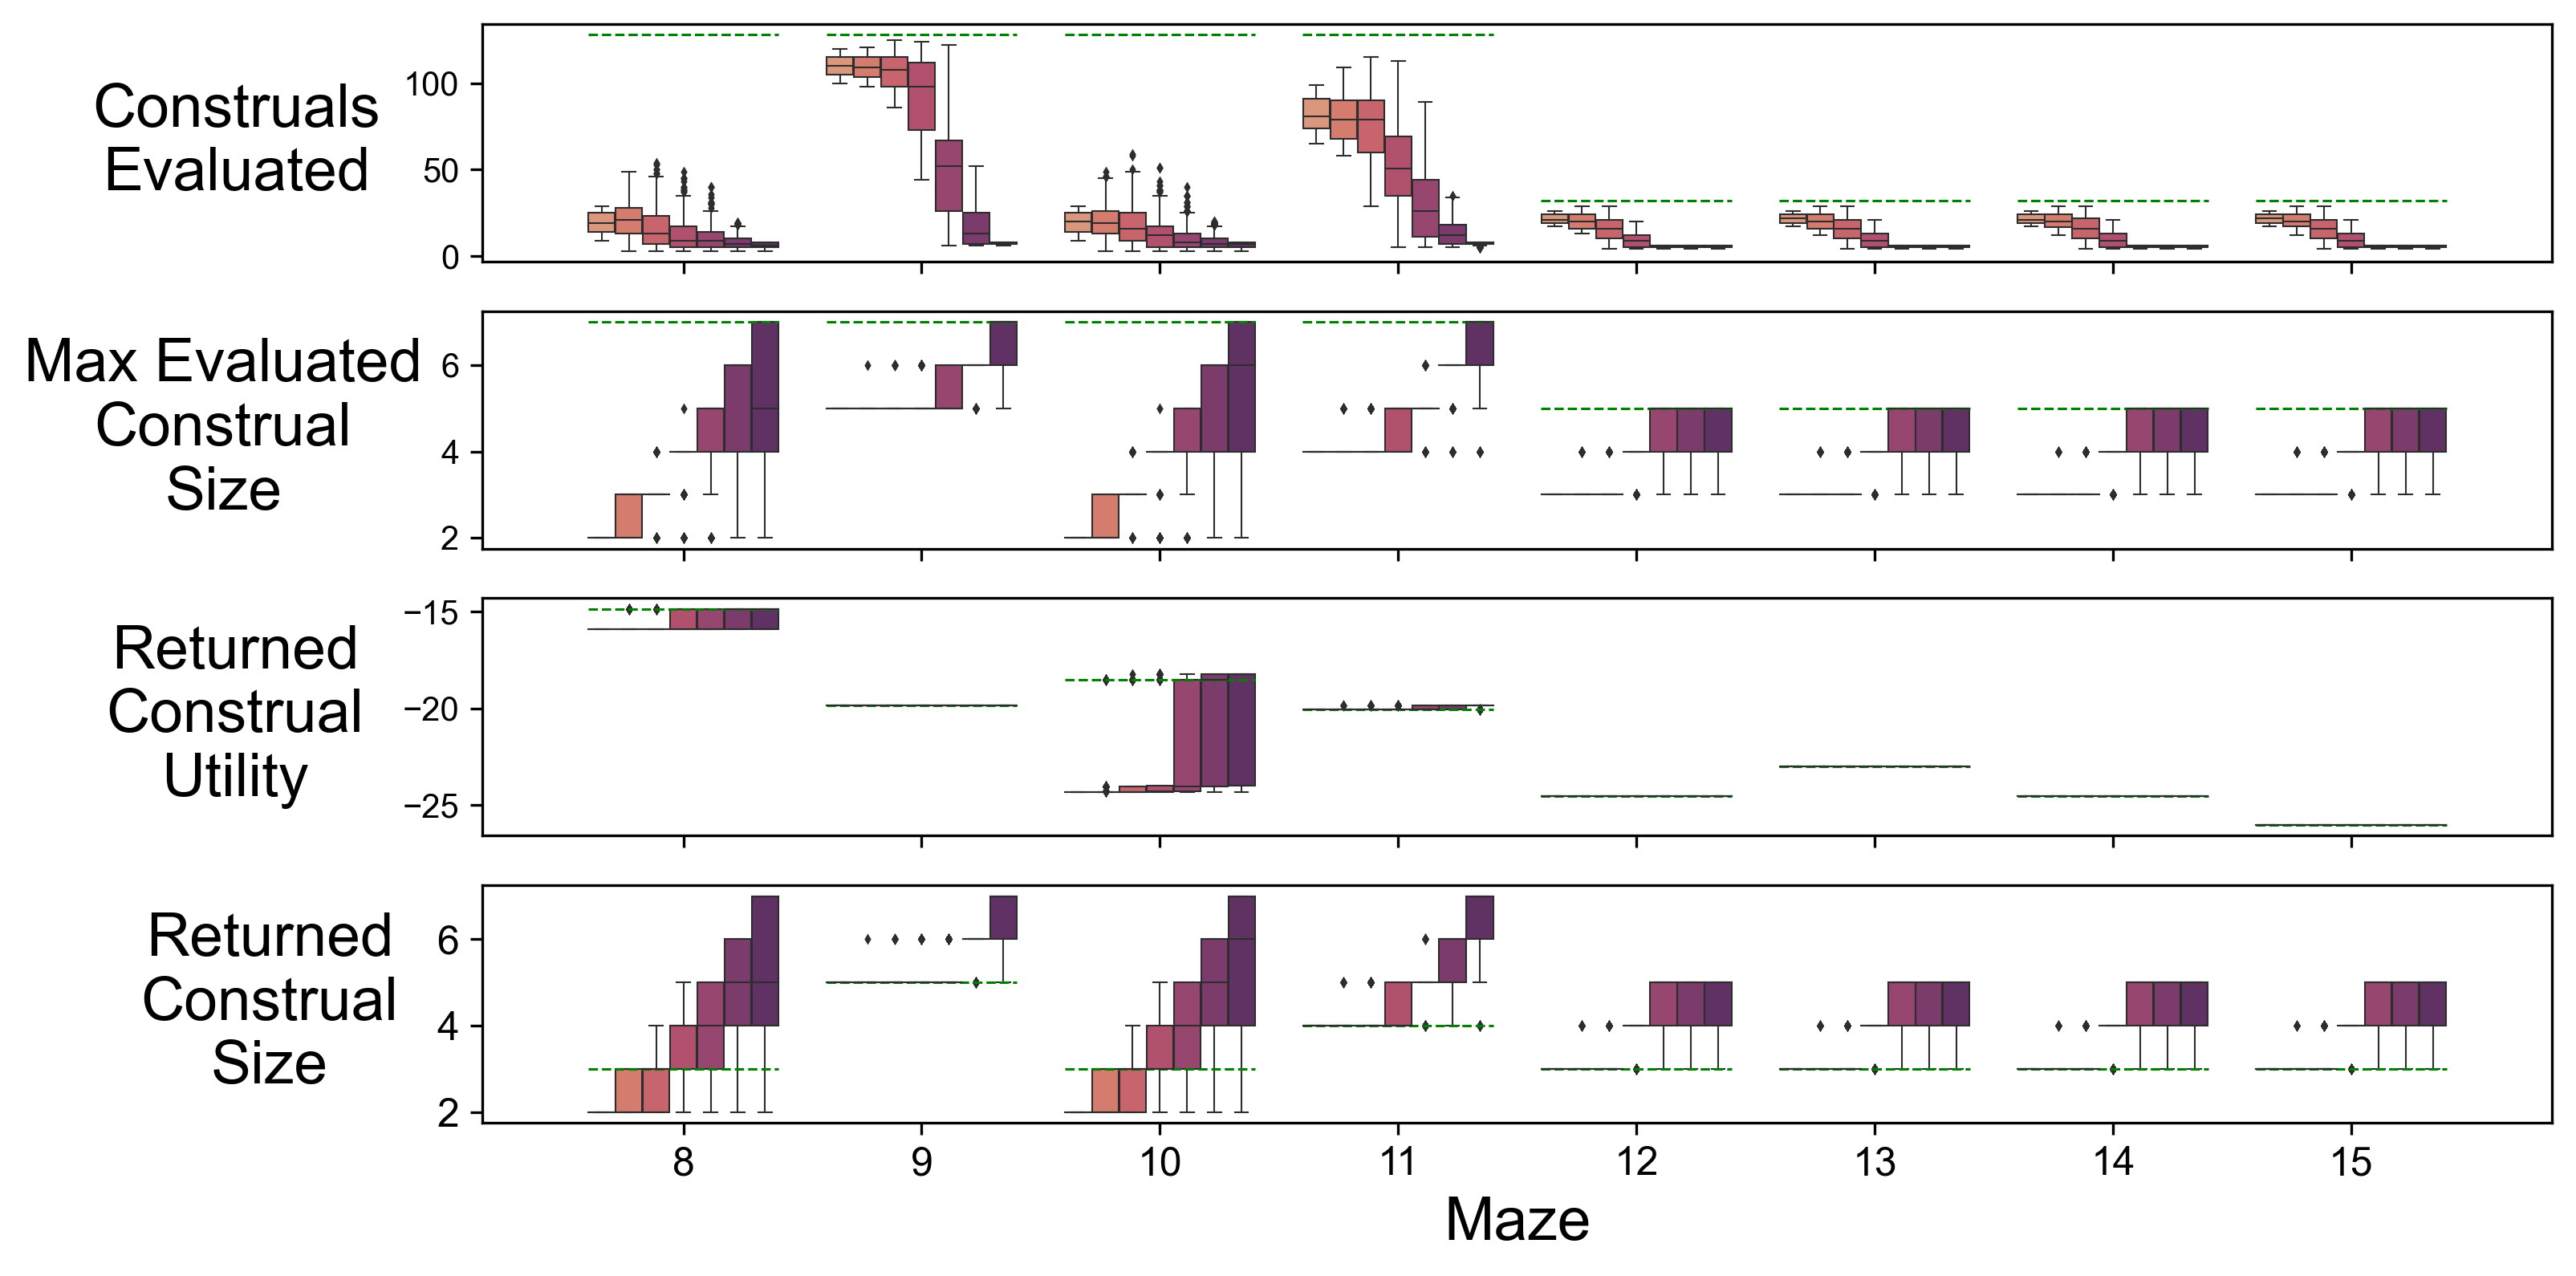

In [14]:
to_plot = sims[sims["Maze"].apply(lambda m: int(m) in range(8,16))]
fig, axes = plt.subplots(4, 1, figsize=(12*.9, 6*.9), dpi=300)
axes = list(axes.flatten())

g = mazes_summary_boxplots(
    to_plot=to_plot,
    measure='construals_evaluated',
    measure_label="Construals\nEvaluated",
    ax=axes.pop(0),
    search_class_order=bdfs_hue_order,
    bdfs_palette=bdfs_palette,
    show_x_labels=False,
    show_legend=False,
)
g = mazes_summary_boxplots(
    to_plot=to_plot,
    measure='max_construal_size',
    measure_label="Max Evaluated\nConstrual\nSize",
    measure_label_pad=65,
    ax=axes.pop(0),
    search_class_order=bdfs_hue_order,
    bdfs_palette=bdfs_palette,
    show_x_labels=False,
    show_legend=False,
)
g = mazes_summary_boxplots(
    to_plot=to_plot,
    measure='construal_utility',
    measure_label="Returned\nConstrual\nUtility",
    ax=axes.pop(0),
    search_class_order=bdfs_hue_order,
    bdfs_palette=bdfs_palette,
    show_x_labels=False,
    show_legend=False,
)
g = mazes_summary_boxplots(
    to_plot=to_plot,
    measure='construal_size',
    measure_label="Returned\nConstrual\nSize",
    ax=axes.pop(0),
    search_class_order=bdfs_hue_order,
    bdfs_palette=bdfs_palette,
    show_x_labels=True,
    show_legend=False,
)
plt.tight_layout()
plt.savefig("construal_search_boxplots_8_15.png")

In [15]:
opt_result = sims.groupby(["search_class", "maze_name"])[
    ['construal_size', 'max_construal_size', 'construals_evaluated']
].mean().reset_index()
opt_result['largest_construal'] = opt_result['max_construal_size']
opt_result['construal_space_size'] = opt_result['construals_evaluated']
opt_result = opt_result[opt_result["search_class"] == 'ExhaustiveSearch']

In [16]:
pd.set_option('display.max_rows', None)
exp_comp_cost = sims.\
    groupby(['search_class', 'maze_name'])[['max_construal_size', 'construals_evaluated']].mean().\
    reset_index()

In [17]:
bfs_exp_cc = exp_comp_cost[exp_comp_cost['search_class'] == 'BreadthFirstSearch'].\
    merge(
        opt_result[['maze_name', 'construal_size', 'largest_construal', 'construal_space_size']],
        on="maze_name"
)
# for BFS, how many evaluate less than 20% of construals
sum((bfs_exp_cc['construals_evaluated']/bfs_exp_cc['construal_space_size']) < .5)

8

In [18]:
opt_size = dict(zip(opt_result.maze_name, opt_result.construal_size))
n_fitted = []
for maze_name in opt_size:
    if 1 < opt_size[maze_name] < 7:
        opt_n_alg = f"BDFS{int(opt_size[maze_name])}"
    elif opt_size[maze_name] == 1:
        opt_n_alg = "BreadthFirstSearch"
    else:
        raise
    mean_evaluated = exp_comp_cost[
        (exp_comp_cost['search_class'] == opt_n_alg) & 
        (exp_comp_cost['maze_name'] == maze_name)
    ]['construals_evaluated'].mean()
    n_fitted.append({
        'maze_name': maze_name,
        'fit_search_class': opt_n_alg,
        'fit_construals_evaluated': mean_evaluated,
    })
n_fitted = pd.DataFrame(n_fitted)
n_fitted = n_fitted.merge(opt_result, on='maze_name')

# proportion when n is fitted
sum((n_fitted['fit_construals_evaluated']/n_fitted['construal_space_size']) < .5)

16

In [19]:
# proportion range when n is fitted
prop_n_fitted = (n_fitted['fit_construals_evaluated']/n_fitted['construal_space_size'])
np.min(prop_n_fitted), np.max(prop_n_fitted)

(0.0493125, 0.4936875)